# Analysis of NP-11-64-10 Sequencing Data

## Overview

This notebook explores and analyzes sequencing data from sample NP-11-64-10, containing approximately 2 million reads. The primary goals are to:

- Align reads to a reference template using minimap2
- Identify relevant positions within a plasmid using a Genbank file
- Group reads based on extracted barcodes and generate consensus sequences using samtools
- Create indexed BAM and BAI files for efficient searchability using pysam
- Parse out desired mutations from aligned consensuses
- Filter barcodes based on identified mutations
- Produce informative metrics and visualizations

## Steps:

1. **Read Alignment with minimap2:**
  - Employ minimap2 with the following parameters for optimal PacBio read alignment:
    `bash minimap2 --MD -Lax map-pb templateFile PacBioFastqFile > alignmentFile`

2. **Plasmid Feature Extraction:**
  - Import a Genbank file containing plasmid sequence information.
  - Locate relevant positions of interest within the plasmid.

3. **Read Grouping and Consensus Generation:**
  - Extract barcodes from aligned reads.
  - Group reads based on their corresponding barcodes.
  - Employ samtools to generate consensus sequences for each barcode group.

4. **Indexing for Efficient Search:**
  - Utilize pysam to create indexed BAM and BAI files, facilitating rapid search capabilities within the alignment data.

5. **Mutation Identification and Filtering:**
  - Align consensus sequences to a reference.
  - Parse out desired mutations from the aligned consensuses.
  - Filter barcodes based on the presence or absence of specific mutations.

6. **Metrics and Visualization:**
  - Calculate and present relevant metrics to summarize sequencing data and analysis results.
  - Generate informative graphs and visualizations to enhance data comprehension.

In [ ]:
# Python modules
import os
import tempfile
import warnings
import Bio.SeqIO
from Bio import SeqIO
from Bio.Align import AlignInfo, MultipleSeqAlignment
import os, io, random
import pandas as pd
import numpy as np
import pysam
from pysam import bcftools
from thefuzz import fuzz
from thefuzz import process
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from scipy.optimize import curve_fit
from scipy.stats import poisson


In [2]:
# Load in .gb file and use it to find relevant features and locations
gbFile = 'np-11-64-1_ScaI_index.gb'
gbRec = SeqIO.read(gbFile, "genbank")
featuresDict = {'Read_name' : []}
featureLocs = {}

# backbone is a join here, needs to be considered as multiple regions
# Positions here are indexed to 1 so we will need to adjust for that too
# Also pay attention to which features are reversed
# I made sure to include stop codons in the two genes

for feature in gbRec.features:
    featuresDict[feature.type] = []
    featureLocs[feature.type] = [int(feature.location.start), int(feature.location.end)]

/opt/homebrew/lib/python3.11/site-packages/Bio/SeqFeature.py:1112: BiopythonParserWarning: Attempting to fix invalid location '4716..2332' as it looks like incorrect origin wrapping. Please fix input file, this could have unintended behavior.
  warnings.warn(


In [3]:
# Get just the barcodes out
alignmentFile = '/Users/noamprywes/NP_11_64_10_PacBio_ScaI_index.sam'
BCDict = {'Read_Name' : [], 'Barcode' : []}
samfile = pysam.AlignmentFile(alignmentFile)
iter = samfile.fetch(until_eof = True)

# Look through alignment one read at a time
# I've edited this to only look through the first 4 as a demonstration, this was already completed
#. It took about 30 min if I remember correctly
for i, read in enumerate(iter):
    if i < 4:
        # These flags are for reads that map forward and reverse
        # This excludes secondary reads to ensure that we only get one alignment per read
        barcode = ''
        if (read.flag == 0) | (read.flag == 16):
            # We can use aligned_pairs to get matched nucleotides between reference and read
            for alignedPair in read.get_aligned_pairs(with_seq = True):
                refPos = alignedPair[1]
                try:
                    # Subtract 1 for 0 index
                    if ((refPos > featureLocs['Barcode'][0] - 1) & \
                        (refPos < featureLocs['Barcode'][1] - 1)):
                        barcode = barcode + read.seq[alignedPair[0]]
                except:
                    pass
            BCDict['Read_Name'].append(read.qname)
            BCDict['Barcode'].append(barcode)
        else:
            pass
    else:
        break

readsBCDF = pd.DataFrame(BCDict)
readsBCDF.to_csv('firstPassAllBarcodes1.csv')
readsBCDF

,Read_Name,Barcode
0,m64365e_230523_200510/5/ccs,AAAAGTGCAGGGCCTGTCCCACAGTTCGA
1,m64365e_230523_200510/7/ccs,TAGTGCGTGTTCGTAATACCTCTAGGAGT
2,m64365e_230523_200510/11/ccs,GGCTACTATATAGGCATGATGCTTCTAAA
3,m64365e_230523_200510/14/ccs,TACGAGTTATTTGTGTGACAGCTAGTGCT


In [3]:
# Generate a dataframe indexed by barcode that has a column for how many counts there are and which reads

readsBCDF = pd.read_csv('firstPassBarcodes.csv')
uniqueBCDF = pd.DataFrame(readsBCDF['Barcode'].value_counts())
uniqueBCDF.reset_index(inplace = True)
# Remove any sequence with fewer than 10 bases in the barcode position
mask = (uniqueBCDF['Barcode'].str.len() > 10)
uniqueBCDF = uniqueBCDF.loc[mask]
uniqueBCDF

,Barcode,count
0,CATTACTACTCGATGGTGAGCTCTCTGAGG,11645
1,GACCCTCAACATAAGTTAACCATGCTTAAG,757
2,GACCTACCGATACCACACACCATGCTTAAG,542
4,GACCCACGTATTTCTGTGGCCATGCTTAAG,416
5,GACCGCGGAGGATAAATCACCATGCTTAAG,365
...,...,...
555587,CTATTTAGTGAGGCGTTCGCCTGAAAGTTG,1
555588,GTAGCCTAATTCATATTCTTTACTACTTTA,1
555589,AATAATTTTAGTCGATCTCAAACGTTTGTG,1
555590,AATTTGCCCGTGAATTCTACATTATAGTGG,1


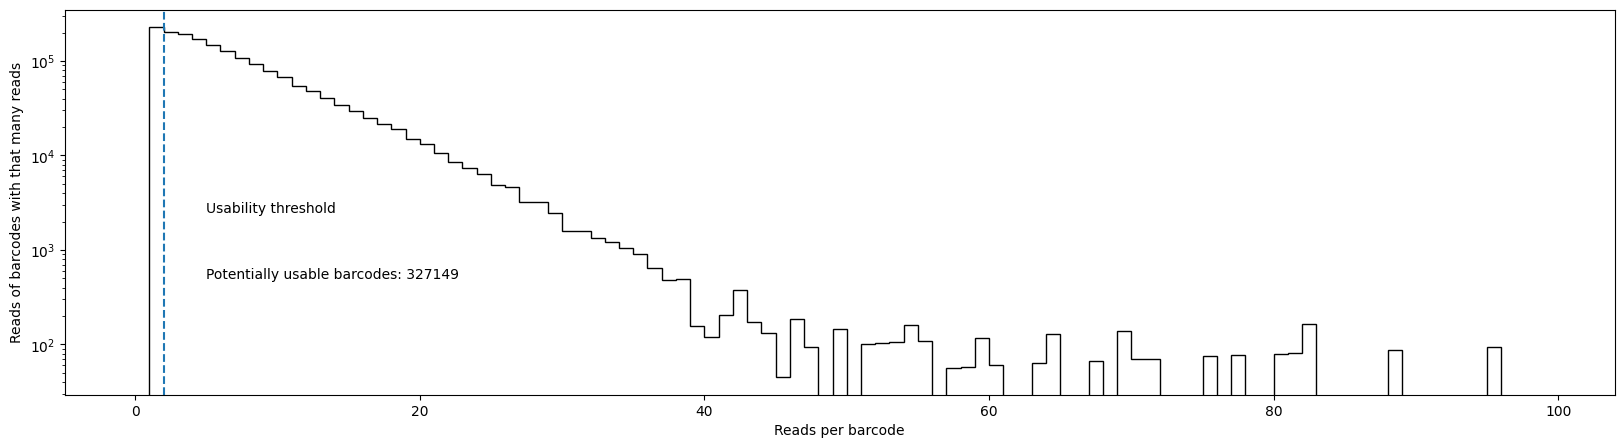

In [4]:
# Histogram with integral that is # of reads
# Find how many barcodes have more than 1 read

readThreshold = 2
usabilityMinimum = len(uniqueBCDF[uniqueBCDF['count'] >= readThreshold])

plt.gcf().set_size_inches((20, 5))
readBChistData = readsBCDF.merge(uniqueBCDF, left_on = 'Barcode', right_on = 'Barcode')
binSet = range(0,100,1)
plt.hist(readBChistData['count'], bins = binSet, histtype = 'step', color = 'black')
plt.yscale('log')
plt.ylabel('Reads of barcodes with that many reads')
plt.xlabel('Reads per barcode')
plt.axvline(x = readThreshold, linestyle = '--')
plt.text(5, 2500, 'Usability threshold')
plt.text(5, 500, 'Potentially usable barcodes: ' + str(usabilityMinimum))
plt.show()

In [5]:
# Try to index the samfile
# First convert to bam

# This takes ~10 min
pysam.sort("-o", "/Users/noamprywes/NP_11_64_10_PacBio_ScaI_index.bam", 
           "/Users/noamprywes/NP_11_64_10_PacBio_ScaI_index.sam")

# Index bamfile

alignmentBAMFile = '/Users/noamprywes/NP_11_64_10_PacBio_ScaI_index.bam'
bamfile = pysam.AlignmentFile(alignmentBAMFile)
indexedBAMFile = pysam.IndexedReads(bamfile)  
indexedBAMFile.build()

[E::idx_find_and_load] Could not retrieve index file for '/Users/noamprywes/NP_11_64_10_PacBio_ScaI_index.bam'


In [21]:
# Use pysam to get consensus sequences - test set

# This is an example with a few barcodes, I already ran this on the whole list. That took ~15 hours
with open('miniConsensus.fasta', 'w') as f:
    
    miniBCList = ['ATAAATAGTAAGGGATCCGTGGTCATTAGG',
                 'AAGTTGTCTCTAGTTTAATGGGTACCCCGG',
                 'GTTGTTTTTTTTCCTGCACTGCTGTCTCTA',
                 'AGCGTTAGTCGGATTTGGGCATTGTTTGTG',
                 'CTTTGCAATGGATTTTGGTTAATTTCTAAT',
                 'TGTCAAGTAAACTTGTTGCGGGGCATTCGT',
                 'GGGTTAGCTTCTTTCAAGTACATATATTGG',
                 'CTTTGAGGTCAGCCTTGCGGTTATATGGGG']

    template = pysam.AlignmentFile('/Users/noamprywes/NP_11_64_10_PacBio_ScaI_index.bam')
    for BC in miniBCList:
        exBCreads = readsBCDF[readsBCDF['Barcode'] == BC]
        BCReads = pysam.AlignmentFile("tempReads.bam", "wb", template = template)
        for read in exBCreads['Read_Name']:
            iterator = indexedBAMFile.find(read)
            for x in iterator:  # x is an alignment
                BCReads.write(x)
        BCReads.close()
        pysam.sort("-o", "tempReadssorted.bam", "tempReads.bam")    

        consensus = ''
        f.write('>' + BC + '\n')
        try:
    #         consensus = pysam.consensus('-l 10000',
    # #                                     '--config hifi',
    #                                     'tempReadssorted.bam')
            consensus = os.popen('samtools consensus -l 100000 --config hifi /Users/noamprywes/Google_Drive/Lab_notebooks/IGI/NP-11-Rr_library/NP-11-64/tempReadssorted.bam').read()
        except Exception as e: print(e)

        f.write(consensus.split()[1] + '\n')


[E::idx_find_and_load] Could not retrieve index file for '/Users/noamprywes/NP_11_64_10_PacBio_ScaI_index.bam'


In [8]:
# Use pysam to get consensus sequences - all barcodes

# startTime = time.time()
# barcodesToConsensus = uniqueBCDF[uniqueBCDF['count'] > 1]['Barcode']

# with open('consensusAttempt060123.fasta', 'w') as f:
#     template = pysam.AlignmentFile('/Users/noamprywes/NP_11_64_10_PacBio_ScaI_index.bam')
#     for i, BC in enumerate(barcodesToConsensus):
#         if (i%10000 == 0) or (i == 200) or (i == 20) or (i == 1000):
#             print(str(100*i/len(barcodesToConsensus)) + '% finished in ' + str(time.time() - startTime) + ' seconds')
#         # Choose all reads of a given barcode
#         # Might be better to make a dataframe where reads of a barcode are already specified
#         exBCreads = readsBCDF[readsBCDF['Barcode'] == BC]
#         # Generate a temporary bam file with those reads
#         BCReads = pysam.AlignmentFile("tempReads.bam", "wb", template = template)
#         for read in exBCreads['Read_Name']:
#             iterator = indexedBAMFile.find(read)
#             for x in iterator:  # x is an alignment
#                 BCReads.write(x)
#         BCReads.close()
#         # The reads need to be resorted or else the consensus command fails
#         pysam.sort("-o", "tempReadssorted.bam", "tempReads.bam")    
#         consensus = ''
#         f.write('>' + BC + '\n')
#         try:
#     #         consensus = pysam.consensus('-l 10000',
#     # #                                     '--config hifi',
#     #                                     'tempReadssorted.bam')
#             # This works better in command line because of the hifi option that doesn't appear to exist in pysam
#             consensus = os.popen('samtools consensus -l 100000 --config hifi /Users/noamprywes/Google_Drive/Lab_notebooks/IGI/NP-11-Rr_library/NP-11-64/tempReadssorted.bam').read()
#         except Exception as e: print(e)

#         f.write(consensus.split()[1] + '\n')


In [9]:
# Align the consensuses to the template in command line
# Took like 3 min
# minimap2 --MD -Lax map-hifi np-11-64-1_ScaI_index.fasta /Users/noamprywes/Google_Drive/Lab_notebooks/IGI/NP-11-Rr_library/NP-11-64/consensusAttempt053123.fasta > np-11-64-1consensus060123.sam

In [10]:
# Look through consensus sequences and find mutations
# This code might handle mutations at the edge of the read oddly, though those are less likely to be real anyway

samfile = pysam.AlignmentFile('/Users/noamprywes/np-11-64-1consensus060123.sam')
mutationDict = {}
startTime = time.time()

for i, BCConsensus in enumerate(samfile):
    # Run on subset as demonstration
    if i > 10:
        break
#     if i % 20000 == 307:
#         print(str(100*i/len(barcodesToConsensus))[:5] + \
#               '% finished in ' + str(time.time() - startTime)[:5] + ' seconds')
    aligned_pairs = BCConsensus.get_aligned_pairs(with_seq = True)
    mutations = []
    refPosNotNone = 0
    for i, (read_pos, ref_pos, ref_base) in enumerate(aligned_pairs):
        # Prevent reference position from being interpreted as None
        if ref_pos != None:
            refPosNotNone = ref_pos
        if ref_base is not None:
            ref_base = ref_base.upper()
        if read_pos is None:
            read_base = None
        else:
            read_base = BCConsensus.query_sequence[read_pos].upper()
        if (read_base != ref_base) and (ref_base != 'N'):
            mutations = mutations + [[ref_base, refPosNotNone, read_base]]
            
    # This makes a dataframe where each barcode is paired with a list of lists of mutations
    mutationDict[BCConsensus.qname] = [mutations]
testMutDF = pd.DataFrame(mutationDict).transpose().reset_index().rename(columns = {'index' : 'Barcode', 
                                           0 : 'Mutation_List'})
testMutDF.to_pickle('testMutationCollection060723.pkl')


In [79]:
barcodesToConsensus = uniqueBCDF[uniqueBCDF['count'] > 1]['Barcode']
barcodesToConsensus

0         CATTACTACTCGATGGTGAGCTCTCTGAGG
1         GACCCTCAACATAAGTTAACCATGCTTAAG
2         GACCTACCGATACCACACACCATGCTTAAG
4         GACCCACGTATTTCTGTGGCCATGCTTAAG
5         GACCGCGGAGGATAAATCACCATGCTTAAG
                       ...              
327818     GTGTGTCGACTAACTTCATTTTTATAAGG
327819    TTGGGAATGAATTACTTGTTCATATTAGAG
327820    GCAGTAAAACTTGTAGCTTTATGACCCATA
327821    CTCATACTTATTTCACCATGTACACGGACG
327822    CTCTACTAGCTATTGCTCATCAGACTCTTC
Name: Barcode, Length: 327149, dtype: object

In [81]:
# Look through consensus sequences and find mutations
# This code might handle mutations at the edge of the read oddly, though those are less likely to be real anyway

samfile = pysam.AlignmentFile('/Users/noamprywes/miniConsensusAlignment.sam')
samfile = pysam.AlignmentFile('/Users/noamprywes/np-11-64-1consensus060123.sam')

mutationDict = {}
startTime = time.time()

nonNoneMuts = 0

for i, BCConsensus in enumerate(samfile):
    
    # Don't consider secondary alignments
    # This prevents a second alignment from taking the place of a primary one
    if not ((BCConsensus.flag == 16) or (BCConsensus.flag == 0)):
        continue
    
    # Run on subset as demonstration
#     if i > 100000:
#         break
    if i % 20000 == 307:
        print(str(100*i/len(barcodesToConsensus))[:5] + \
              '% finished in ' + str(time.time() - startTime)[:5] + ' seconds')
#     if i == 8:
#         print(aligned_pairs)    
        
    aligned_pairs = BCConsensus.get_aligned_pairs(with_seq = True)

    mutations = []
    
    for i, (read_pos, ref_pos, ref_base) in enumerate(aligned_pairs):
                
        if ref_base is not None:
            ref_base = ref_base.upper()
            
        if read_pos is None:
            read_base = None
            
        else:
            read_base = BCConsensus.query_sequence[read_pos].upper()
            
        if (read_base != ref_base) and (ref_base != 'N'):
            mutations = mutations + [[ref_base, ref_pos, read_base]]
    
            
    # This makes a dataframe where each barcode is paired with a list of lists of mutations
    mutationDict[BCConsensus.qname] = [mutations]
testMutDF = pd.DataFrame(mutationDict).transpose().reset_index().rename(columns = {'index' : 'Barcode', 
                                           0 : 'Mutation_List'})
testMutDF



0.093% finished in 0.535 seconds
6.207% finished in 33.40 seconds
12.32% finished in 65.31 seconds
18.43% finished in 98.67 seconds
24.54% finished in 132.1 seconds
30.66% finished in 167.2 seconds
36.77% finished in 201.6 seconds
42.88% finished in 235.3 seconds
49.00% finished in 268.8 seconds
55.11% finished in 301.8 seconds
61.22% finished in 334.4 seconds
67.34% finished in 367.0 seconds
73.45% finished in 399.6 seconds
79.56% finished in 432.3 seconds
85.68% finished in 466.2 seconds
91.79% finished in 499.1 seconds
97.90% finished in 531.5 seconds


,Barcode,Mutation_List
0,CATTACTACTCGATGGTGAGCTCTCTGAGG,[]
1,GACCCTCAACATAAGTTAACCATGCTTAAG,"[[A, 2905, G], [A, 3737, None], [G, 3738, None..."
2,GACCTACCGATACCACACACCATGCTTAAG,"[[A, 2905, G], [A, 3737, None], [G, 3738, None..."
3,GACCCACGTATTTCTGTGGCCATGCTTAAG,"[[A, 2681, T], [A, 3737, None], [G, 3738, None..."
4,GACCGCGGAGGATAAATCACCATGCTTAAG,"[[A, 2681, T], [A, 3737, None], [G, 3738, None..."
...,...,...
327144,GTGTGTCGACTAACTTCATTTTTATAAGG,"[[G, 2515, T], [G, 2815, T], [G, 2893, T], [T,..."
327145,TTGGGAATGAATTACTTGTTCATATTAGAG,"[[G, 2515, T], [G, 3235, T], [None, None, T], ..."
327146,GCAGTAAAACTTGTAGCTTTATGACCCATA,"[[None, None, T], [G, 3661, A], [C, 3662, T]]"
327147,CTCATACTTATTTCACCATGTACACGGACG,"[[T, 124, N], [G, 126, N], [T, 188, N], [None,..."


In [82]:
testMutDF.to_pickle('testMutationCollection061623.pkl')

In [88]:
testMutDF[testMutDF['Barcode'] == 'TAATGTTTTTGTTGTTTGGTGACGGCGCGT']

,Barcode,Mutation_List
286988,TAATGTTTTTGTTGTTTGGTGACGGCGCGT,"[[C, 3340, G], [G, 3341, C], [T, 3342, G], [No..."


In [84]:
# Retreive mutation information

mutationDF = pd.read_pickle('testMutationCollection061623.pkl')

In [91]:
# Write out mutation logic for each barcode - save as .csv

def findMutLocs(mutList):
    mutLocs = []
    for mutation in mutList:
        mutLocs.append(mutation[1])
    return mutLocs
def findBBmut(row):
    mutLocs = findMutLocs(row['Mutation_List'])
    bbMutFound = False
    for position in mutLocs:
        try:
            if (position <= featureLocs['rbcL'][0]) or (position >= featureLocs['PRK'][1]):
                bbMutFound = True
            if (position >= featureLocs['BCleft'][0]) and (position <= featureLocs['BCleft'][1]):
                bbMutFound = True
            if (position >= featureLocs['BCright'][0]) and (position <= featureLocs['BCright'][1]):
                bbMutFound = True
        except:
            pass
    return bbMutFound
def findInsertions(row):
    insFound = False
    for mutation in row['Mutation_List']:
        # If there is no assigned reference base that indicates an insertion
        if mutation[2] == None:
            insFound = True
    return insFound
def findDeletions(row):
    delFound = False
    for mutation in row['Mutation_List']:
        # If there is no assigned read base that indicates a deletion
        if mutation[0] == None:
            delFound = True
    return delFound
def findPRKmut(row):
    mutLocs = findMutLocs(row['Mutation_List'])
    PRKMutFound = False
    for position in mutLocs:
        try:
            if (position >= featureLocs['PRK'][0]) and (position <= featureLocs['PRK'][1]):
                PRKMutFound = True
        except:
            pass
    return PRKMutFound
PROGRAMMED_MUTATION_CODONS = ['CGT','CAT','AAA','GAT','GAA',
                              'AGC','ACC','AAT','CAG','TGC',
                              'GGC','CCG','GCG','GTG','ATT',
                              'CTG','ATG','TTT','TAT','TGG']
rbcLDNA = 'ATGGACCAGAGTTCTCGCTATGTCAATCTTGCTTTGAAAGAAGAGGACTTAATTGCCGGAGGCGAACACGTATTGTGCGCCTATATTATGAAACCAAAAGCTGGGTACGGTTACGTTGCCACCGCAGCGCACTTTGCTGCAGAGAGTTCGACTGGAACAAATGTAGAGGTGTGTACCACTGATGATTTTACTCGTGGCGTGGATGCCTTAGTTTACGAAGTAGATGAGGCCCGCGAGCTTACTAAGATTGCCTACCCAGTAGCACTGTTCGATCGTAATATCACGGATGGAAAAGCTATGATCGCATCATTTCTTACATTGACCATGGGCAATAATCAAGGCATGGGTGACGTAGAATATGCCAAAATGCATGACTTCTATGTGCCTGAAGCGTATCGCGCTCTGTTTGATGGCCCTTCTGTAAATATTTCCGCCTTGTGGAAGGTACTGGGTCGTCCGGAGGTTGATGGAGGCTTAGTTGTCGGTACTATCATTAAACCAAAGCTTGGGCTGCGCCCTAAGCCTTTCGCTGAGGCTTGCCACGCATTTTGGTTAGGTGGTGATTTTATTAAAAATGATGAACCGCAAGGGAACCAACCCTTCGCGCCACTTCGCGACACGATCGCCTTGGTTGCAGATGCGATGCGCCGTGCACAGGACGAAACGGGTGAAGCAAAGTTGTTTAGTGCTAATATCACCGCTGATGACCCGTTTGAAATCATCGCCCGCGGGGAATACGTTCTTGAAACATTCGGTGAAAATGCAAGTCACGTTGCCTTATTAGTAGACGGATACGTAGCCGGCGCAGCTGCTATTACGACCGCTCGTCGCCGTTTCCCCGATAATTTCTTGCATTATCATCGCGCCGGGCATGGAGCGGTCACTAGCCCTCAGTCTAAGCGCGGCTATACTGCTTTTGTGCATTGTAAGATGGCTCGTTTGCAAGGTGCGTCGGGTATCCATACCGGAACTATGGGCTTTGGAAAGATGGAAGGGGAGTCCTCAGATCGTGCCATCGCGTATATGTTAACTCAAGATGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAGGCCTGCACCCCTATTATTTCTGGCGGAATGAATGCCTTACGCATGCCCGGCTTCTTCGAAAATCTTGGTAATGCGAATGTCATCCTGACTGCTGGTGGCGGTGCTTTCGGCCATATTGACGGCCCTGTGGCCGGCGCTCGTTCTCTTCGCCAAGCTTGGCAGGCGTGGCGCGATGGCGTCCCTGTGCTTGACTACGCCCGCGAGCATAAGGAGTTGGCACGTGCTTTTGAGTCCTTCCCTGGCGACGCTGACCAGATTTATCCAGGTTGGCGTAAGGCGCTTGGAGTGGAGGATACTCGTTCAGCTTTACCTGCG'
rbcLAA = 'MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFAAESSTGTNVEVCTTDDFTRGVDALVYEVDEARELTKIAYPVALFDRNITDGKAMIASFLTLTMGNNQGMGDVEYAKMHDFYVPEAYRALFDGPSVNISALWKVLGRPEVDGGLVVGTIIKPKLGLRPKPFAEACHAFWLGGDFIKNDEPQGNQPFAPLRDTIALVADAMRRAQDETGEAKLFSANITADDPFEIIARGEYVLETFGENASHVALLVDGYVAGAAAITTARRRFPDNFLHYHRAGHGAVTSPQSKRGYTAFVHCKMARLQGASGIHTGTMGFGKMEGESSDRAIAYMLTQDEAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTAGGGAFGHIDGPVAGARSLRQAWQAWRDGVPVLDYAREHKELARAFESFPGDADQIYPGWRKALGVEDTRSALPA'
def translate(seq): 
    table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W', 
    } 
    protein ="" 
    if len(seq)%3 == 0: 
        for i in range(0, len(seq), 3): 
            codon = seq[i:i + 3] 
            protein += table[codon] 
    return protein 
def rbcLMut(row):
    mutLocs = findMutLocs(row['Mutation_List'])
    mutLocsInFrame = []
    affectedCodons = []
    rbcLMutList = []
    originalCodon = 'XXX'
    mutantCodon = 'YYY'
    originalAA = 'X'
    mutPosition = -1
    mutantAA = 'Y'
    aaMut = 'X0Y'
    for i, position in enumerate(mutLocs):
        try:
            if (position >= featureLocs['rbcL'][0]) and (position <= featureLocs['rbcL'][1]): 
                rbcLMutList.append(row['Mutation_List'][i])
                # position-1 gets the position with a 0 index
                # dividing by 3 and taking the floor gets the codon position
                # The codon position already has a 0 index
                mutPosition = math.floor((position-featureLocs['rbcL'][0])/3)
                if mutPosition not in (affectedCodons):
                    affectedCodons.append(mutPosition)
        except:
            pass
    if len(affectedCodons) == 0:
        aaMut = 'WT'
        return aaMut, originalAA, (mutPosition + 1), mutantAA
    
    try:
        if len(affectedCodons) == 1:
            originalCodon = rbcLDNA[affectedCodons[0] * 3 : affectedCodons[0] * 3 + 3]
            mutCodonSeqList = list(originalCodon)
            for mutationNumber, mutation in enumerate(rbcLMutList):
                withinCodonPosition = (mutation[1] - featureLocs['rbcL'][0])%3
                mutCodonSeqList[withinCodonPosition] = mutation[2]
                mutantCodon = ''.join(mutCodonSeqList)
        else:
            aaMut = 'Multiple_mutations'
            return aaMut, originalAA, (mutPosition + 1), mutantAA
        
    except:
        aaMut = 'Ambiguous_mutation'
        return aaMut, originalAA, (mutPosition + 1), mutantAA
    
    if mutantCodon not in PROGRAMMED_MUTATION_CODONS:
        aaMut = 'Illegal_mutation'
        return aaMut, originalAA, (mutPosition + 1), mutantAA
    
    if (originalCodon != 'XXX') and (mutantCodon != 'YYY'):
        originalAA = translate(originalCodon)
        mutantAA = translate(mutantCodon)
        if originalAA == mutantAA:
            aaMut = mutantAA = 'Silent mutation'
        elif mutantAA == '_':
            aaMut = mutantAA = 'Nonsense mutation'
        else:
            # Add one to get out of zero-indexing
            aaMut = (originalAA + str(mutPosition + 1) + mutantAA)
    return aaMut, originalAA, (mutPosition + 1), mutantAA
    
mutationDF['BackboneMut'] = mutationDF.apply(lambda row: findBBmut(row), axis = 1)
mutationDF['InsertionsFound'] = mutationDF.apply(lambda row: findInsertions(row), axis = 1)
mutationDF['DeletionsFound'] = mutationDF.apply(lambda row: findDeletions(row), axis = 1)
mutationDF['PRKmut'] = mutationDF.apply(lambda row: findPRKmut(row), axis = 1)
mutationDF['RbcLCodonMut'], mutationDF['originalAA'], mutationDF['AApos'], mutationDF['mutAA'] =  zip(*mutationDF.apply(rbcLMut, axis = 1))

mutationDF.to_csv('NP_11_64_10_allBarcodes.csv')

# Filter away barcodes that break the rules

betterMutsDF = mutationDF[
                          ~mutationDF['BackboneMut'] & 
                          ~mutationDF['InsertionsFound'] & 
                          ~mutationDF['DeletionsFound'] &
                          ~mutationDF['PRKmut']
                         ]

betterMutsDF = betterMutsDF[
    (betterMutsDF['RbcLCodonMut'] != 'Multiple_mutations') &
    (betterMutsDF['RbcLCodonMut'] != 'Silent mutation') &
    (betterMutsDF['RbcLCodonMut'] != 'Ambiguous_mutation') &
    (betterMutsDF['RbcLCodonMut'] != 'Illegal_mutation')
]

filtered_df = betterMutsDF[betterMutsDF.groupby('RbcLCodonMut')['RbcLCodonMut'].transform('size') >= 3]
filtered_df[['Barcode',
             'RbcLCodonMut',
             'originalAA',
             'AApos',
             'mutAA']].to_csv('NP_11_64_10_lookupTable061623.csv')
filtered_df


,Barcode,Mutation_List,BackboneMut,InsertionsFound,DeletionsFound,PRKmut,RbcLCodonMut,originalAA,AApos,mutAA
0,CATTACTACTCGATGGTGAGCTCTCTGAGG,[],False,False,False,False,WT,X,0,Y
45,AGGAATTGTCTGCTTATATGGTTAACGGAT,[],False,False,False,False,WT,X,0,Y
49,AACGCTTTGTACGCTCGGTGTCACCAATCT,[],False,False,False,False,WT,X,0,Y
51,ATATCATGGTTTCATACTTCTTAAAAACCA,[],False,False,False,False,WT,X,0,Y
54,CGTAGGTATCTTAGGTTTGTGGCCGTTTTG,[],False,False,False,False,WT,X,0,Y
...,...,...,...,...,...,...,...,...,...,...
327111,GTGGCCGATAAATTATTTCATCTTTTCTGT,"[[G, 2620, A], [G, 2621, T], [A, 2622, T]]",False,False,False,False,G97I,G,97,I
327119,AACCTTTGCTGGGCCTGGGGTTTCGGTCCT,"[[A, 2356, G], [A, 2357, G], [T, 2358, C]]",False,False,False,False,N9G,N,9,G
327122,GGCATATGTAAGTTTTTCAGTCAAATTCGC,"[[G, 2527, T], [G, 2528, T], [C, 2529, T]]",False,False,False,False,G66F,G,66,F
327126,CGATAAGGATCAACGACTGGTTGAGTTAGG,"[[G, 2377, C], [A, 2378, C], [C, 2379, G]]",False,False,False,False,D16P,D,16,P


In [95]:
# Some stats

usableReads = uniqueBCDF[uniqueBCDF['Barcode'].isin(filtered_df['Barcode'])]['count'].sum()
totalReads = uniqueBCDF['count'].sum()
print(str(100*usableReads/totalReads)[:5] + '% of reads should be usable at t0')
totalMutsWithBC = betterMutsDF['RbcLCodonMut'].nunique()
totalmutationsExpected = 8778
print(str(100*totalMutsWithBC/totalmutationsExpected)[:5] + '% of mutations with at least one barcode')
totalMutsBCCounts = pd.DataFrame(filtered_df.groupby('RbcLCodonMut').size()).reset_index().rename(columns = 
                                                                                {0 : 'HowManyBarcodes'})
totalMutsWithThreeOrMoreBC = totalMutsBCCounts[totalMutsBCCounts['HowManyBarcodes'] >= 3]
print(str(100*len(totalMutsWithThreeOrMoreBC)/totalmutationsExpected)[:5] + 
      '% of mutations with at least three barcodes')
print(str(100*len(totalMutsWithThreeOrMoreBC)/(totalmutationsExpected + (19*3)))[:5] + 
      '% of mutations with at least three barcodes if we include the second and last two codons')


53.88% of reads should be usable at t0
99.90% of mutations with at least one barcode
99.78% of mutations with at least three barcodes
99.13% of mutations with at least three barcodes if we include the second and last two codons


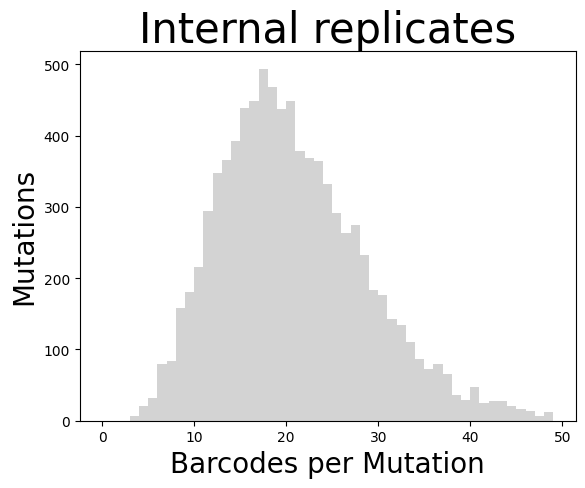

In [96]:
# Histogram of barcodes per mutation

mutBCCounts = filtered_df.groupby('RbcLCodonMut').count()['Barcode']

binSet = range(0,50,1)
histData = plt.hist(mutBCCounts,
                    bins = binSet,
                    color = 'lightgray')
plt.title('Internal replicates', size = 30)
plt.ylabel('Mutations', size = 20)
plt.xlabel('Barcodes per Mutation', size = 20)

plt.savefig('NP_11_64_barcodesPerMutHist.pdf')
plt.show()

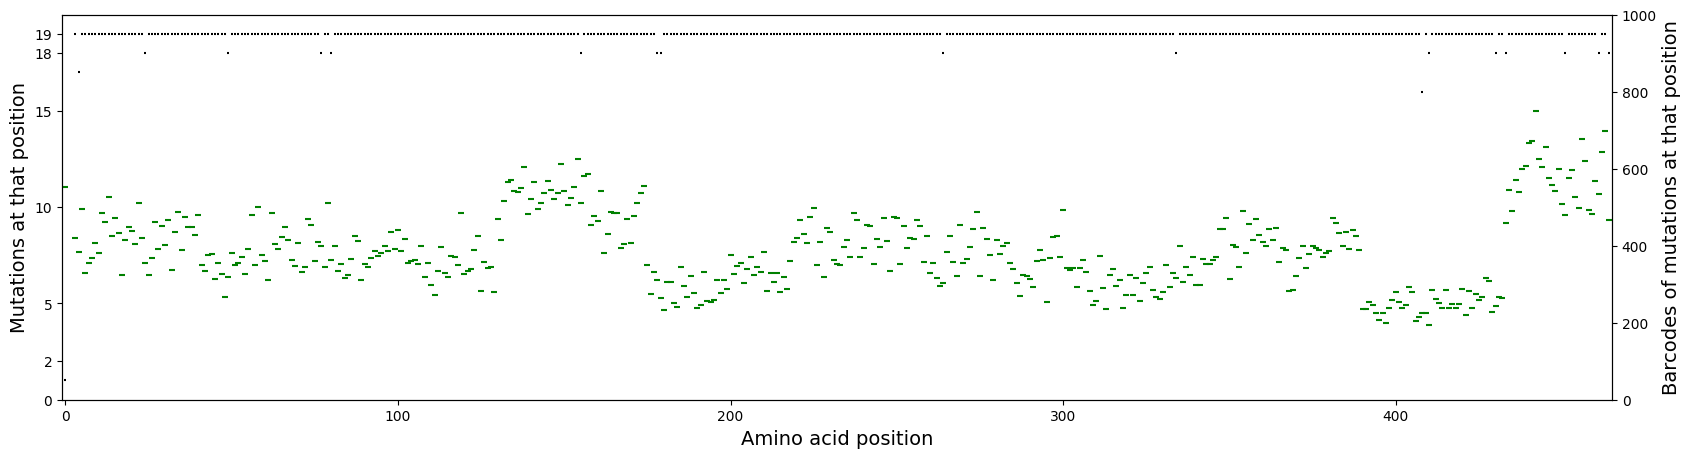

In [97]:
# Scatter of barcodes per position

binSet = range(1,466,1)


posVsmuts = pd.DataFrame(filtered_df.groupby('AApos').apply(lambda x: 
                                    x.RbcLCodonMut.nunique())).reset_index().rename(columns = {0 : 'mutsAtPos'})
mutationBCsByPosition = filtered_df.groupby('AApos')['Barcode'].count()

fig,ax = plt.subplots()
plt.gcf().set_size_inches((20, 5))    

ax.scatter(x = posVsmuts['AApos'], 
            y = posVsmuts['mutsAtPos'], \
            s = 3, 
            color = 'black', 
            marker = "_")
ax.set_xlabel("Amino acid position",fontsize=14)

ax.set_ylabel("Mutations at that position",fontsize=14)
ax.set_ylim([0, 20])
ax.set_xlim([-1, 465])
ax.set_yticks([0, 2, 5, 10, 15, 18, 19])

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.scatter(mutationBCsByPosition.index,
            mutationBCsByPosition,
            s = 25,
            color = 'green',
            marker = '_')
ax2.set_ylabel("Barcodes of mutations at that position",fontsize=14)
ax2.set_ylim(0, 1000)

plt.savefig('NP_11_64_barcodesPerPosHist.pdf')
plt.show()


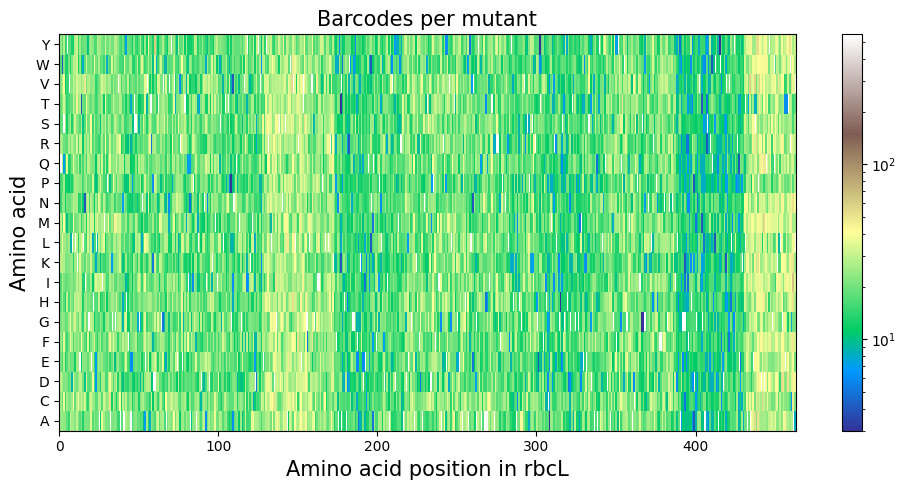

In [98]:
# Heatmap showing each individual mutation barcode frequency
# This will only give the barcode heatmap for now

positionAAFreq = filtered_df.groupby(['AApos', 'mutAA']).size()
dfPositionAAFreq = positionAAFreq.to_frame(name = 'Barcodes')
pivotBCs = dfPositionAAFreq.pivot_table(index = 'mutAA', columns = 'AApos', values = 'Barcodes')

fig, (ax1) = plt.subplots(1, tight_layout=True, figsize=(10,5), dpi = 100)
pcmBCs = ax1.pcolor(pivotBCs,
                    cmap = 'terrain',
                    norm=matplotlib.colors.LogNorm()
                   )

ax1.set_title('Barcodes per mutant', size = 15)
ax1.set_xlabel('Amino acid position in rbcL', size = 15)
ax1.set_ylabel('Amino acid', size = 15)
# This sets the ticks in the middle
ax1.set_yticks(np.arange(0.5, 20.5))
ax1.set_yticklabels(pivotBCs.index)
fig.colorbar(pcmBCs, ax = ax1)

plt.savefig('NP_11_64_9_mutationBCHist.pdf')

plt.show()

In [99]:
# Rarefaction curves data

rarefactionData = []

n = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
howOftenToSample = 100000

readsBCDF['index'] = np.arange(len(readsBCDF))

for read in readsBCDF['index']:
    num = read%howOftenToSample
    if (num == 0) or (read in n):
#         for label in filterLabels:
        filteredBCsUpToRead = readsBCDF['Barcode'][:read]
        rarefactionData.append([filteredBCsUpToRead.count(), filteredBCsUpToRead.nunique()])
            
rarefactionDataTransposed = []
# Transpose values
# for label in filterLabels:
BCcounts, unique_BCs = list(map(list, zip(*rarefactionData)))
rarefactionDataTransposed = BCcounts, unique_BCs  

# Look just at barcodes that go through all filters

rarefactionDataFiltered = []

filteredBCReads = readsBCDF[readsBCDF['Barcode'].isin(filtered_df['Barcode'])]

filteredBCReads['index'] = np.arange(len(filteredBCReads))

for read in filteredBCReads['index']:
    num = read%howOftenToSample
    if (num == 0) or (read in n):
#         for label in filterLabels:
        filteredBCsUpToRead = filteredBCReads['Barcode'][:read]
        rarefactionDataFiltered.append([filteredBCsUpToRead.count(), filteredBCsUpToRead.nunique()])
            
rarefactionFilteredDataTransposed = []
# Transpose values
# for label in filterLabels:
BCcounts, unique_BCs = list(map(list, zip(*rarefactionDataFiltered)))
rarefactionFilteredDataTransposed = BCcounts, unique_BCs  

/var/folders/l6/fc3bk71n25s7py0cw5ypmdzw0000gn/T/ipykernel_1137/3199776402.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredBCReads['index'] = np.arange(len(filteredBCReads))


Negative binomial skew estimate: 0.41


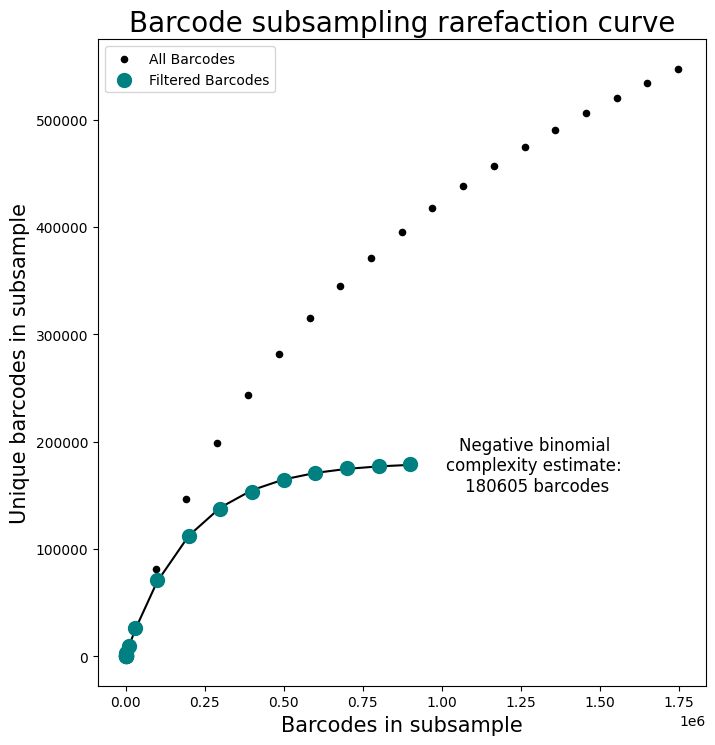

In [100]:
# Plot rarefaction

plt.rcParams["figure.figsize"] = (7,7)

# Fit to negative binomial distribution curve

def negativeBinomial(x, a, b):
    return a*(1-np.power(b, x/a))  # a*(1-b^(x/a))

xdata = rarefactionFilteredDataTransposed[0]
ydata = rarefactionFilteredDataTransposed[1]

popt, pcov = curve_fit(f = negativeBinomial, \
                      xdata = xdata, \
                      ydata = ydata, \
                      p0=[10000, 0.5], \
                      bounds=(0, np.inf))

estText = "Negative binomial \ncomplexity estimate: \n" + str(int(popt[0])) + ' barcodes'
print("Negative binomial skew estimate: " + str(popt[1])[:4])

# Plot the curve above
plt.plot(xdata, negativeBinomial(xdata, *popt), color = 'black', zorder = 0)
plt.tight_layout()
plt.text(1300000, 150000, estText, fontsize=12, horizontalalignment='center', verticalalignment='bottom')

plt.scatter(rarefactionDataTransposed[0],
            rarefactionDataTransposed[1],
            color = 'black',
            label = 'All Barcodes',
            s = 20)
plt.scatter(rarefactionFilteredDataTransposed[0],
            rarefactionFilteredDataTransposed[1],
            color = 'teal',
            label = 'Filtered Barcodes',
            s = 100)

plt.legend(loc='upper left')

plt.title('Barcode subsampling rarefaction curve', size = 20)
plt.xlabel('Barcodes in subsample', size = 15)
plt.ylabel('Unique barcodes in subsample', size = 15)


plt.savefig('NP_11_64_9_rarefaction.pdf')
plt.show()

In [101]:
# Track down a consensus sequence

samfile = pysam.AlignmentFile('/Users/noamprywes/np-11-64-1consensus060123.sam')
for i, BCConsensus in enumerate(samfile):
    if BCConsensus.qname == 'TTGTATCTTAACTGTAGCTCCAGAAAGGTG':
        print(BCConsensus.seq)
#         print(BCConsensus.qual[2510:2520])

In [102]:
# Track down reads of a barcode

exBCreads = readsBCDF[readsBCDF['Barcode'] == 'TTGTATCTTAACTGTAGCTCCAGAAAGGTG']
#         BCReads = pysam.AlignmentFile("tempReads.bam", "wb", template = template)
for read in exBCreads['Read_Name']:
    iterator = indexedBAMFile.find(read)
    for x in iterator:  # x is an alignment
        print(x.seq)

In [103]:
# Collect mutation locations

mutationPositions = []
for row in mutationDF.iloc:
    mutationList = row.Mutation_List
    for mutation in mutationList:
        mutationPositions.append(mutation[1])
        

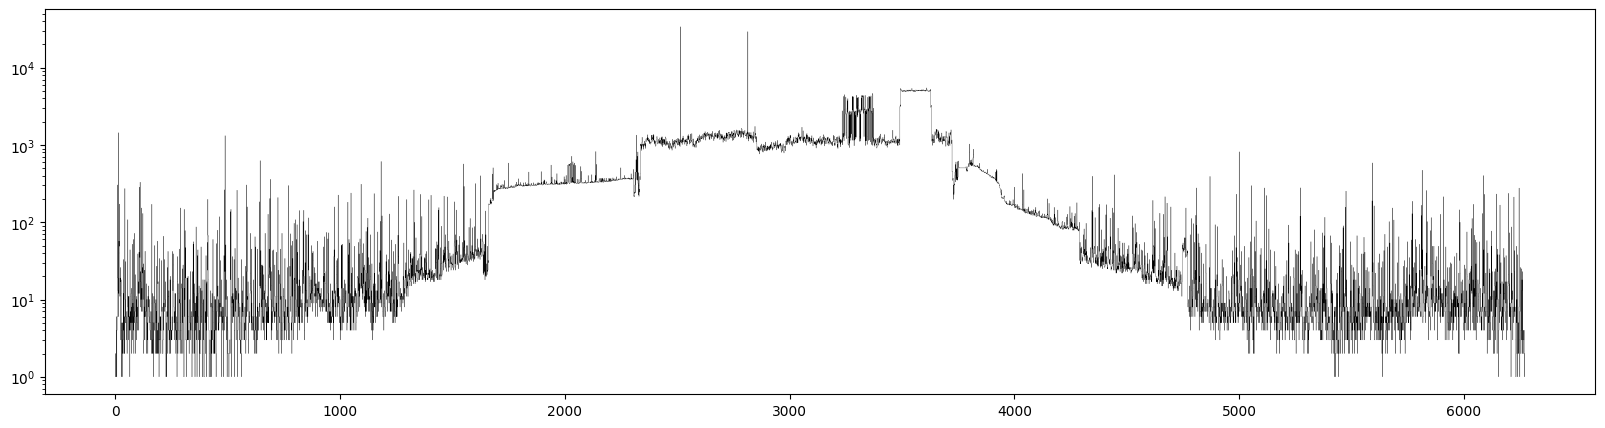

In [104]:
# View as line graph (this misses ther barcode)

mutPosData = pd.Series(mutationPositions).dropna().value_counts().sort_index()
plt.gcf().set_size_inches((20, 5))
plt.plot(mutPosData.index,
           mutPosData,
           lw = 0.2,
           color = 'black',
           drawstyle = 'steps'
        )
# plt.xlim(3000,4000)
plt.yscale('log')
# plt.ylim(0,10000)
plt.show()

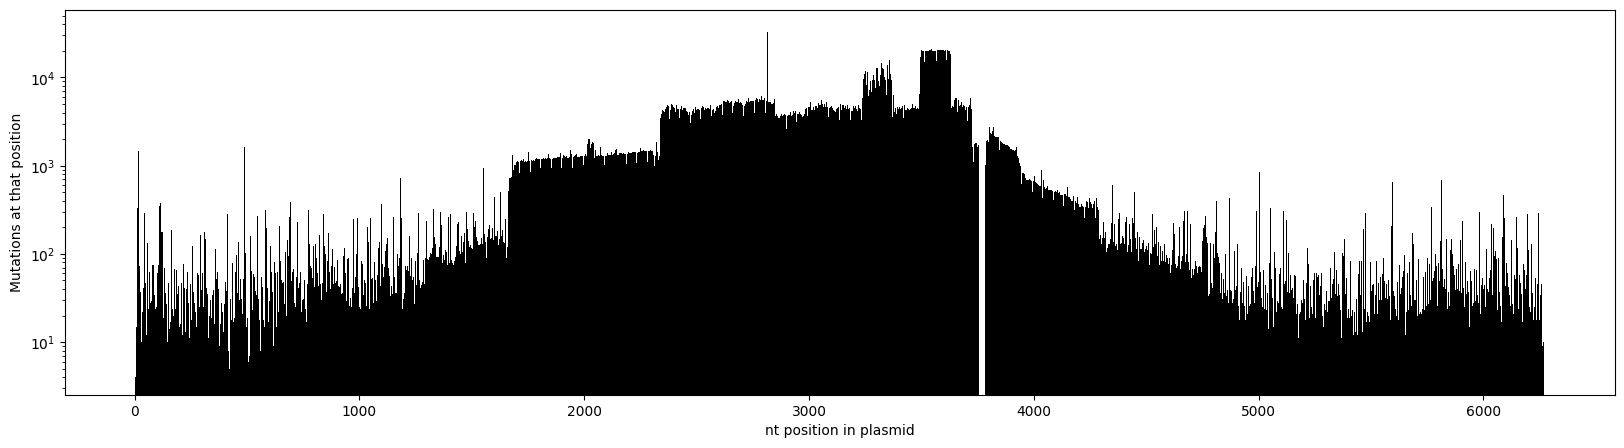

In [105]:
# View as histogram (can have weird artifacts and lose signal at 2815)

plt.gcf().set_size_inches((20, 5))

plt.hist(pd.Series(mutationPositions).dropna(),
         bins = 1600,
         color = 'black')
plt.xlabel('nt position in plasmid')
plt.ylabel('Mutations at that position')
# plt.xlim(2800,2820)
plt.yscale('log')
plt.show()